In [16]:
import planetary_computer as pc
import pystac_client
import rioxarray
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans

In [17]:
# Step 1: Search and Load a Landsat Image from MPC
catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

# Define a sample AOI and time range
search = catalog.search(
    collections=["landsat-c2-l2"],
    bbox=[-105.0, 39.5, -104.5, 40.0],  # Example: Bounding Box around Denver, CO
    datetime="2023-01-01/2023-12-31",
    limit=1
)

item = next(search.get_items())
print("Selected Item:", item.id)

/root/miniconda3/lib/python3.12/site-packages/pystac_client/item_search.py:888: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


Selected Item: LC08_L2SP_033033_20231227_02_T1


In [18]:
# Sign asset HREFs
asset_hrefs = {key: pc.sign(asset.href) for key, asset in item.assets.items()}

# Open relevant bands (e.g., B2, B3, B4 for RGB)
bands = ["red", "green", "blue"]  # Blue, Green, Red
arrays = [
    rioxarray.open_rasterio(asset_hrefs[band]).squeeze() for band in bands
]

In [9]:
# Stack bands into a single array
stacked_array = np.stack([arr.values for arr in arrays], axis=-1)

In [10]:
# Mask invalid values (e.g., clouds, fill values)
valid_mask = np.all(stacked_array > 0, axis=-1)
valid_data = stacked_array[valid_mask]

In [11]:
# Step 2: Apply MiniBatch KMeans Clustering
n_clusters = 10
kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=1024)
kmeans.fit(valid_data)

# Assign clusters to the full image
cluster_labels = -1 * np.ones(stacked_array.shape[:2], dtype=int)
cluster_labels[valid_mask] = kmeans.predict(valid_data)

In [12]:
# Step 3: Compute Average Spectral Signatures
cluster_means = np.zeros((n_clusters, stacked_array.shape[-1]))
for cluster in range(n_clusters):
    cluster_data = valid_data[kmeans.labels_ == cluster]
    cluster_means[cluster] = cluster_data.mean(axis=0)

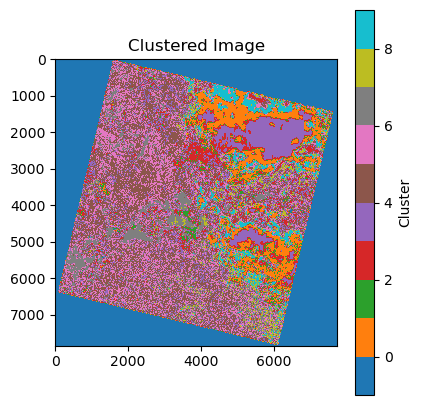

In [13]:
# Step 4: Visualization
# (a) Plot the clustered image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Clustered Image")
plt.imshow(cluster_labels, cmap="tab10")
plt.colorbar(label="Cluster")

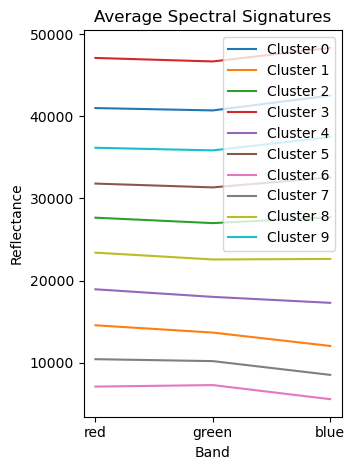

In [14]:
# (b) Plot average spectral signatures
plt.subplot(1, 2, 2)
plt.title("Average Spectral Signatures")
for i, mean in enumerate(cluster_means):
    plt.plot(mean, label=f"Cluster {i}")
plt.xticks(range(len(bands)), bands)
plt.xlabel("Band")
plt.ylabel("Reflectance")
plt.legend()
plt.tight_layout()
plt.show()

/root/miniconda3/lib/python3.12/site-packages/pystac_client/item_search.py:888: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


Selected Item: LC08_L2SP_033033_20231227_02_T1


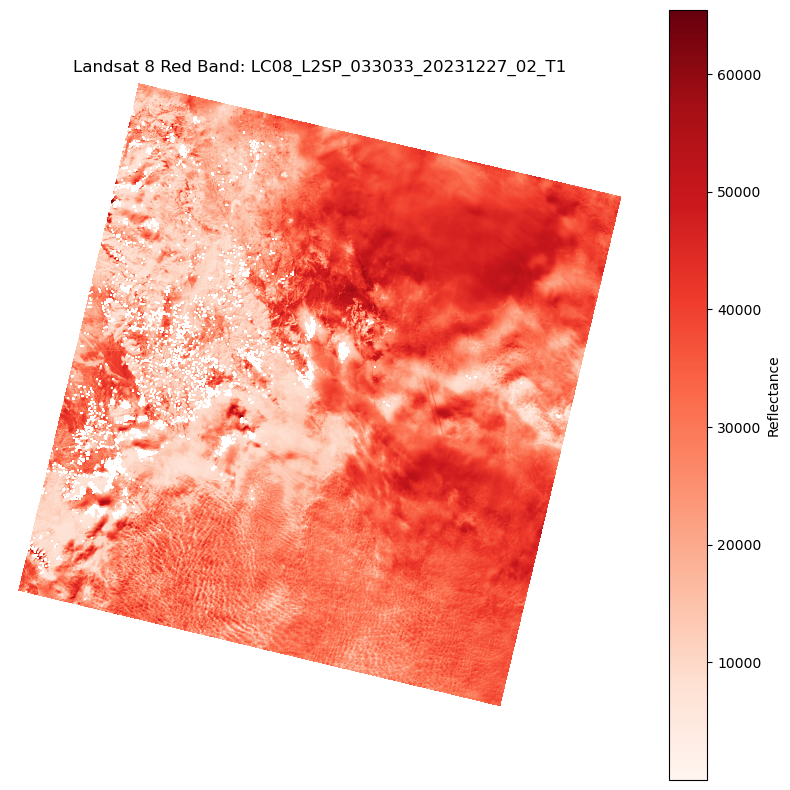

In [5]:
import matplotlib.pyplot as plt
import rioxarray

# Step 1: Search and Load a Landsat Image from MPC
from pystac_client import Client

catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

# Define a sample AOI and time range
search = catalog.search(
    collections=["landsat-c2-l2"],
    bbox=[-105.0, 39.5, -104.5, 40.0],  # Example: Bounding Box around Denver, CO
    datetime="2023-01-01/2023-12-31",
    limit=1
)

item = next(search.get_items())
print("Selected Item:", item.id)

# Step 2: Access the COG URL for the red band
assets = item.assets
red_url = assets["red"].href

# Authenticate URL (if needed)
import planetary_computer as pc

red_url = pc.sign(red_url)

# Step 3: Load the red band using rioxarray
red = rioxarray.open_rasterio(red_url, masked=True)

# Step 4: Plot the red band
plt.figure(figsize=(10, 10))
plt.imshow(red.squeeze(), cmap="Reds")  # Use .squeeze() to remove the single-band dimension
plt.colorbar(label="Reflectance")
plt.title(f"Landsat 8 Red Band: {item.id}")
plt.axis("off")
plt.show()
